In [1]:
import sys
import os

from copy import deepcopy
import h5py

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# Import torch
import torch
from torch import nn

myhost = os.uname()[1]
sys.path.insert(0, '/home/elott1/code/')
data_dir = "/home/elott1/data/packaged/"
work_dir = '/home/elott1/code/NTdatasets/hartley/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")

print(f'Running on Computer: [{myhost}]')
print(f'Data directory: {data_dir}')
print(f'Working directory: {work_dir}')

%load_ext autoreload
%autoreload 2

# NDN tools
import NDNT.utils as utils          # some other utilities\n",
from NDNT.utils import imagesc      # because I'm lazy\n",
from NDNT.utils import ss           # because I'm real lazy\n",
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

fn0 = 'Jocamo_220628_full_HC_ETCC_nofix_v08'
f = h5py.File(os.path.join(data_dir, fn0+'.mat'), 'r')

Running on Computer: [PFC]
Data directory: /home/elott1/data/packaged/
Working directory: /home/elott1/code/NTdatasets/hartley/
Invoking __init__.py for NDNT.utils


In [2]:
from NTdatasets.hartley.hartley import HartleyDataset

expts = [fn0]

data = HartleyDataset(
    filenames=expts,
    datadir=data_dir,
    num_lags=10,
    time_embed=2,
    include_MUs=True,
    preload=True,
    drift_interval=None,
    device=device0,
    eye_config=3,
    maxT=10000
)

Loading data into memory...
Stim: using laminar probe stimulus
  Adding fixation point
  Time embedding...
  Done
  Time embedding...
	Done
T-range: 0 10000
Extending final block at  9840 10000


In [3]:
Reff = data.robs * data.dfs
nspks = torch.sum(Reff, axis=0)
stas0 = ((data.meta.T @ Reff).squeeze() / nspks).reshape([data.one_hots.shape[3],data.num_lags,-1]).numpy()

'''NC = 10
nrows = int(np.ceil(NC/5))
ss(nrows,5)
for cc in range(NC):
    plt.subplot(nrows,5, cc+1)
    imagesc(stas0[8:20,:, cc])
    plt.title(str(cc))
plt.show()'''

'NC = 10\nnrows = int(np.ceil(NC/5))\nss(nrows,5)\nfor cc in range(NC):\n    plt.subplot(nrows,5, cc+1)\n    imagesc(stas0[8:20,:, cc])\n    plt.title(str(cc))\nplt.show()'

In [4]:
lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-10,
    tolerance_grad=1e-10,
    batch_size=1000,
    max_iter=200)

XTreg = 1.0
L1reg = 0.0001

glm_layer = NDNLayer.layer_dict(
    input_dims=[1,1,data.one_hots.shape[3],data.num_lags],
    num_filters=data.NC,
    bias=True,
    NLtype='softplus',
    initialize_center=False)

glm_layer['reg_vals'] = {'d2xt': XTreg, 'l1': L1reg}
stim_net = FFnetwork.ffnet_dict(xstim_n='meta', layer_list=[glm_layer])

In [5]:
torch.cuda.empty_cache()
tr_ind = data.train_inds
v_ind = data.val_inds

glm = NDN.NDN(  
    ffnet_list = [stim_net],
    loss_type='poisson')

glm.fit(data, train_inds=tr_ind, force_dict_training=True, **lbfgs_pars, verbose=2)

Model: M201_N

GPU Available: True, GPU Used: True
Iteration: 0 | Loss: 0.7969207763671875
Iteration: 1 | Loss: 0.796481728553772
Iteration: 2 | Loss: 0.4645231366157532
Iteration: 3 | Loss: 0.44388580322265625
Iteration: 4 | Loss: 0.4279388189315796
Iteration: 5 | Loss: 0.4240344166755676
Iteration: 6 | Loss: 0.4145575761795044
Iteration: 7 | Loss: 0.41425809264183044
Iteration: 8 | Loss: 0.40849781036376953
Iteration: 9 | Loss: 0.40667566657066345
Iteration: 10 | Loss: 0.40504515171051025
Iteration: 11 | Loss: 0.4030207097530365
Iteration: 12 | Loss: 0.4030607342720032
Iteration: 13 | Loss: 0.4017464816570282
Iteration: 14 | Loss: 0.4014958441257477
Iteration: 15 | Loss: 0.4009822607040405
Iteration: 16 | Loss: 0.40057823061943054
Iteration: 17 | Loss: 0.40028974413871765
Iteration: 18 | Loss: 0.40003713965415955
Iteration: 19 | Loss: 0.39980438351631165
Iteration: 20 | Loss: 0.39956822991371155
Iteration: 21 | Loss: 0.3994436264038086
Iteration: 22 | Loss: 0.3990950286388397
Iterati

In [6]:
LLi = glm.eval_models(data, val_inds=v_ind, null_adjusted=True)
print(LLi)
print(np.mean(LLi))

Eval models: 100%|██████████| 10/10 [00:01<00:00,  9.73it/s]


[ 0.07011461  0.07406282  0.22870827  0.13173509  0.09033966  0.14843488
  0.1103065   0.05899501  0.08037686  0.03203511  0.04930258  0.01751959
  0.04017091  0.07469273  0.04889631  0.09641814  0.04450583  0.11750269
  0.09037852  0.18572974  0.06969953  0.09136081  0.48301148  0.03389096
  0.03417659  0.06348276  0.12273192  0.10126388  0.17725825  0.02565289
  0.03931117  0.03171182  0.02244496  0.02066469  0.00428629  0.03478813
  0.03323078  0.04424047  0.03404927  0.02805686  0.04080606  0.03763819
  0.02313495  0.04324508  0.02609181  0.04375005  0.02895927  0.04431009
  0.0320673   0.02255249  0.03943491  0.03051019  0.02699757  0.02217913
  0.01245129  0.05122614  0.03177738  0.0312295   0.06083202  0.02612233
  0.03067827  0.02583671  0.01471615  0.02853227  0.02947974  0.02505136
  0.02914381  0.01436496  0.02986932  0.03463078  0.01614213  0.02375603
  0.03511882  0.04086471  0.03897476  0.02803802  0.02668095  0.03727841
  0.02417135  0.02147317  0.04497957  0.03728533  0

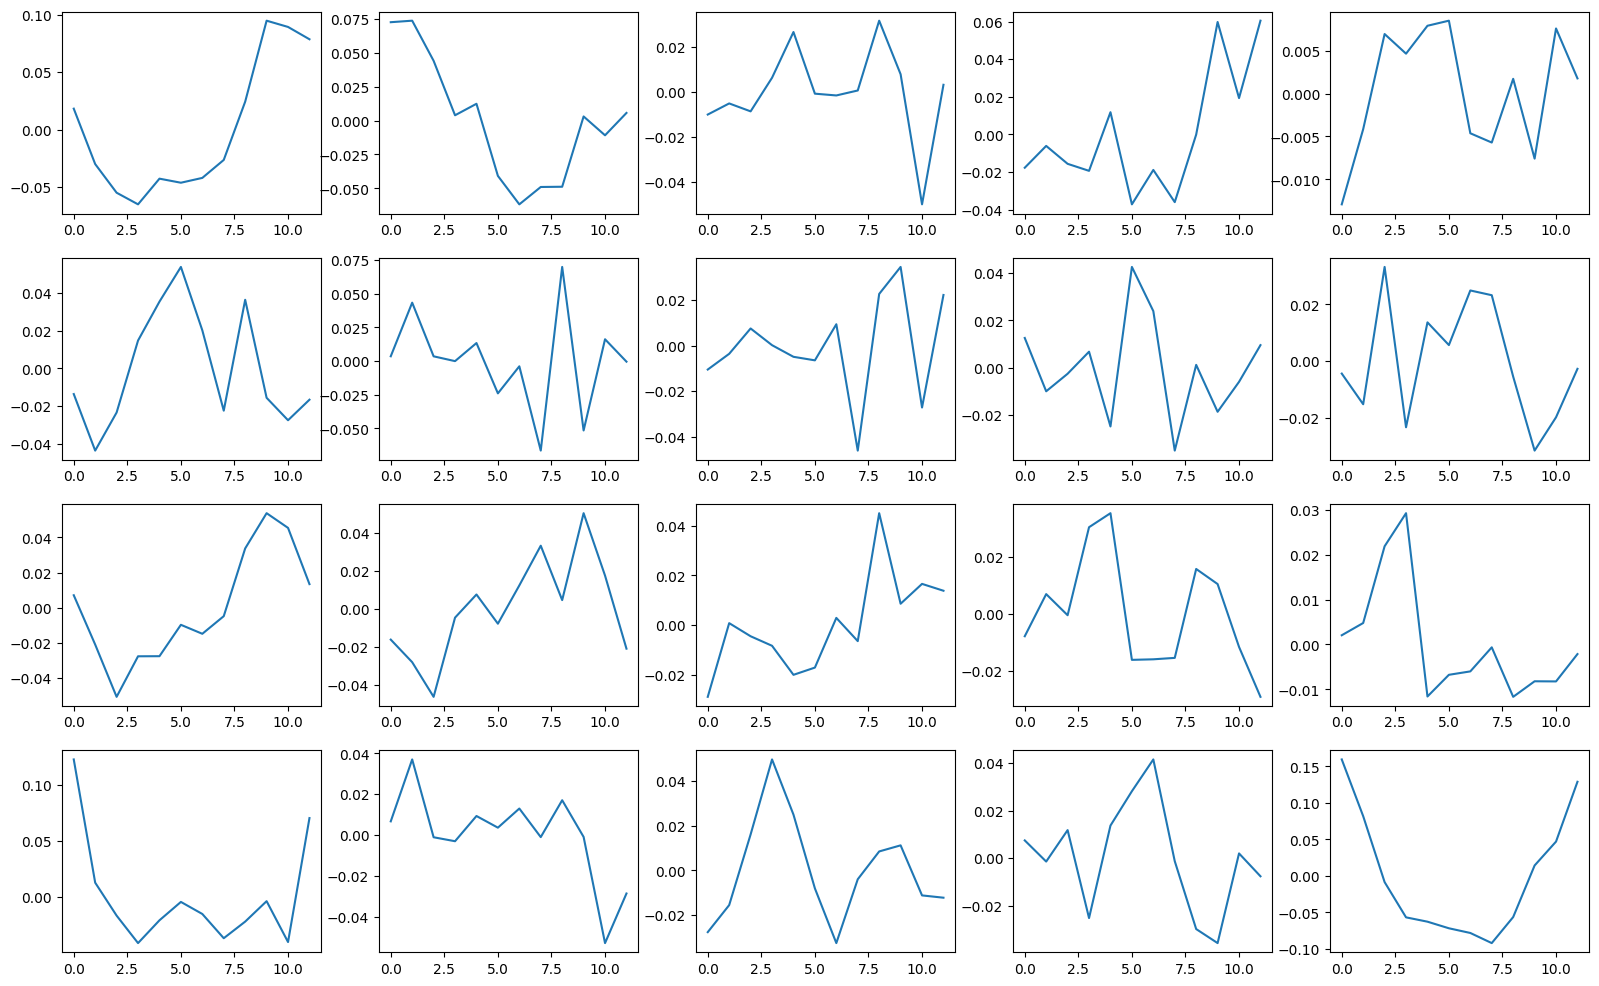

In [7]:
k = glm.get_weights()
k_sf = k[:8]
k_or = k[8:20]
k_ph = k[20:24]
k_co = k[24:]

NC=20
ss(round(NC/5), 5)
for cc in range(NC):
    plt.subplot(round(NC/5), 5, cc+1)
    plt.plot(k[8:20][:,3,cc])
plt.show()

In [8]:
# Best lag for spacial frequency.
best_lags = [np.argmax(np.var(k_sf[:,:,cc], axis=0)) for cc in range(k_sf.shape[2])]
opt_lag = np.bincount(best_lags).argmax()
print(f'Optimal spacial frequency lag: {opt_lag}')

# Best lag for orientation.
best_lags = [np.argmax(np.var(k_or[:,:,cc], axis=0)) for cc in range(k_or.shape[2])]
opt_lag = np.bincount(best_lags).argmax()
print(f'Optimal orientation lag: {opt_lag}')

# Best lag for phase shift.
best_lags = [np.argmax(np.var(k_ph[:,:,cc], axis=0)) for cc in range(k_ph.shape[2])]
opt_lag = np.bincount(best_lags).argmax()
print(f'Optimal phase shift lag: {opt_lag}')

# Best lag for color.
best_lags = [np.argmax(np.var(k_co[:,:,cc], axis=0)) for cc in range(k_co.shape[2])]
opt_lag = np.bincount(best_lags).argmax()
print(f'Optimal color lag: {opt_lag}')

Optimal spacial frequency lag: 6
Optimal orientation lag: 3
Optimal phase shift lag: 4
Optimal color lag: 3


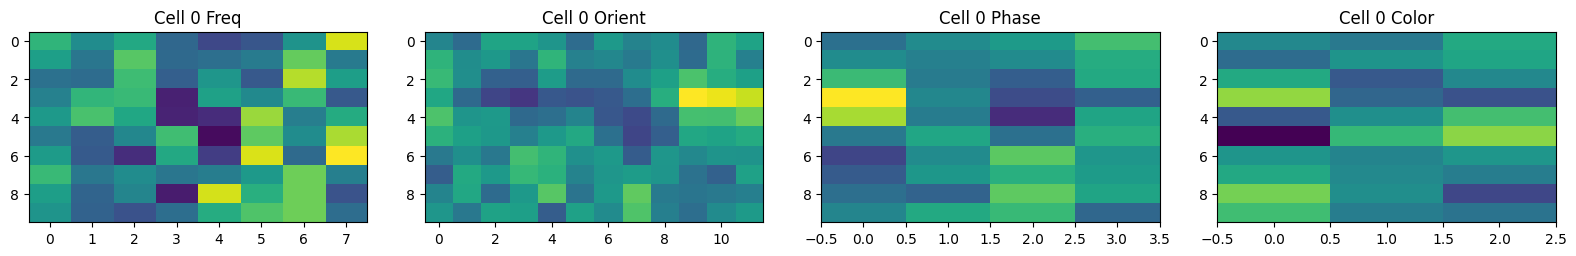

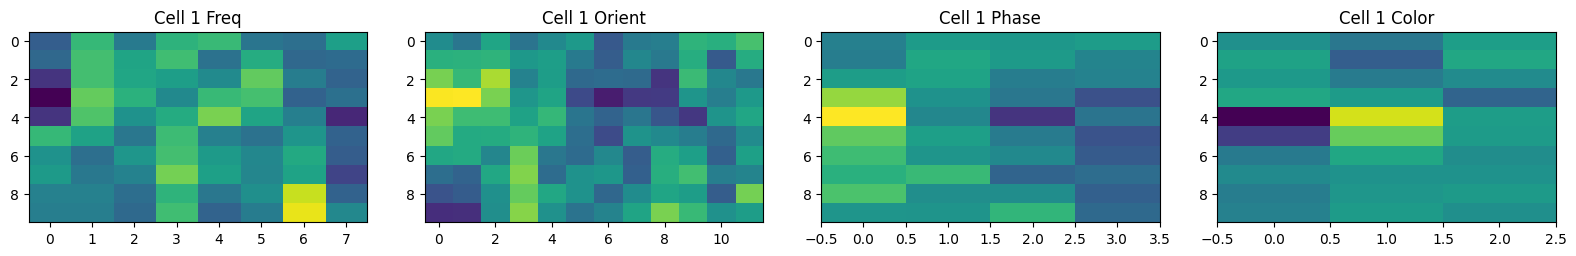

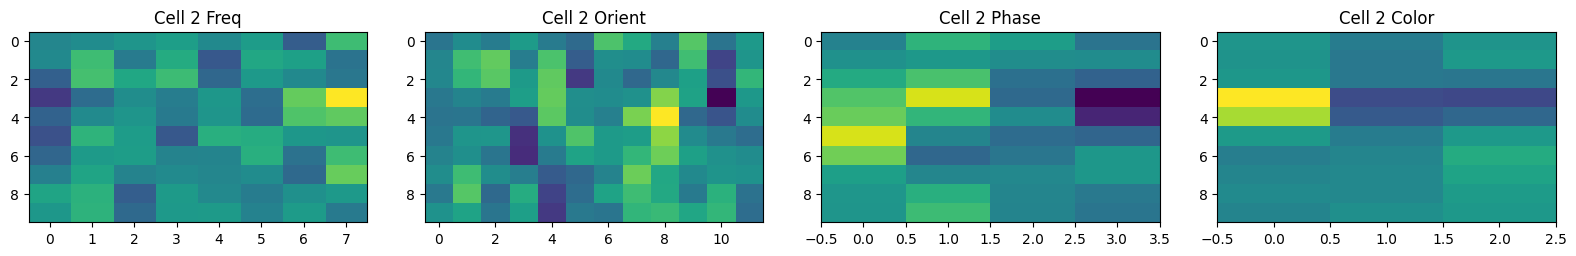

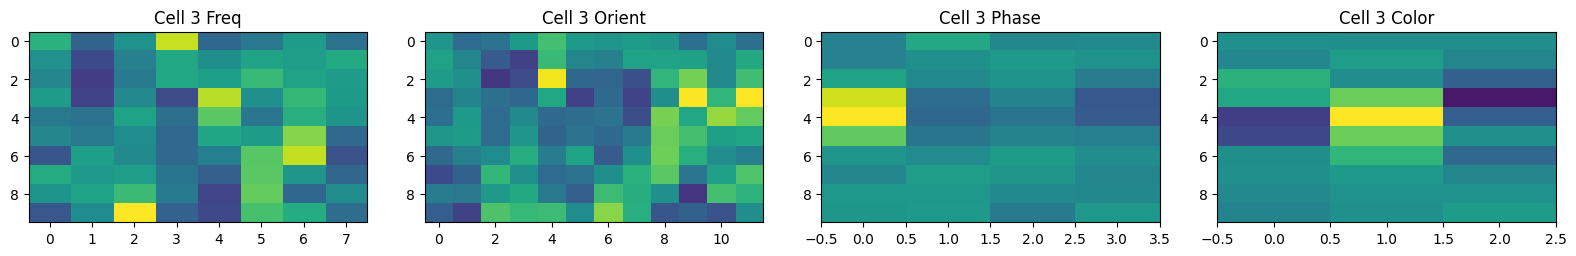

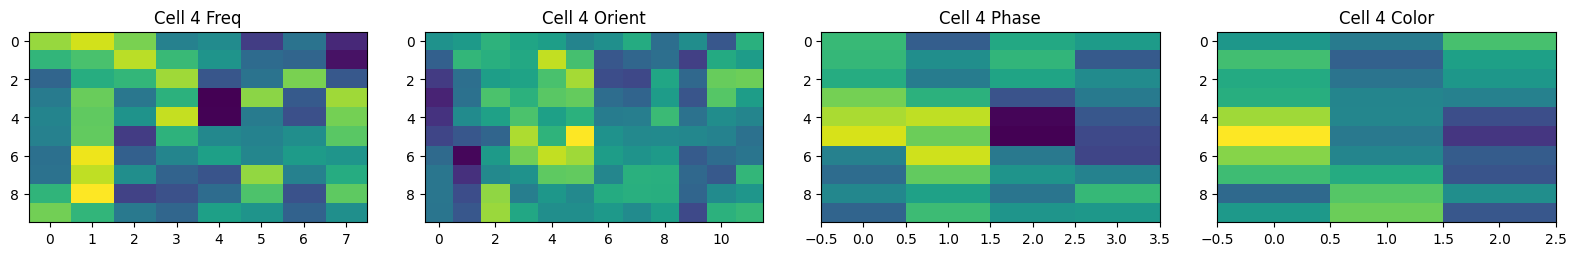

In [9]:
k_sf = k[:8]
k_or = k[8:20]
k_ph = k[20:24]
k_co = k[24:]

cells = 5
for cc in range(cells):
    ss(1, 4)
    plt.subplot(1, 4, 1)
    plt.title(f'Cell {str(cc)} Freq')
    imagesc(k_sf[:,:,cc])
    plt.subplot(1, 4, 2)
    plt.title(f'Cell {str(cc)} Orient')
    imagesc(k_or[:,:,cc])
    plt.subplot(1, 4, 3)
    plt.title(f'Cell {str(cc)} Phase')
    imagesc(k_ph[:,:,cc])
    plt.subplot(1, 4, 4)
    plt.title(f'Cell {str(cc)} Color')
    imagesc(k_co[:,:,cc])
plt.show()